In [1]:
import requests
import pandas as pd
import json
import csv

Data Collection

In [ ]:
# Hourly
hourly_url = "https://archive-api.open-meteo.com/v1/archive?latitude=-37.8228&longitude=145.0389&start_date=2010-01-01&end_date=2024-08-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,wind_direction_10m,wind_direction_80m,wind_direction_120m,wind_direction_180m,wind_gusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_to_1cm,soil_moisture_1_to_3cm,soil_moisture_3_to_9cm,soil_moisture_9_to_27cm,soil_moisture_27_to_81cm"

# Send a GET request to fetch the data
response = requests.get(hourly_url)

# Check if the request was successful
if response.status_code == 200:
    # Write the response content to a file
    with open("hourly_data.json", "w") as file:
        file.write(response.text)
    print("Data saved to hourly_data.json")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

# Daily
daily_url = ""

response = requests.get(hourly_url)

# Check if the request was successful
if response.status_code == 200:
    # Write the response content to a file
    with open("daily_data.json", "w") as file:
        file.write(response.text)
    print("Data saved to daily_data.json")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

In [ ]:
# Converting JSON to CSV
# Hourly
file_name = "hourly"
json_file_name =  file_name + ".json"
output_file = file_name + ".csv"

with open(json_file_name, 'r') as file:
    data = json.load(file)

hourly_data = data.get("hourly", {})

if not hourly_data:
    print("No valid hourly data found in the JSON file.")
    exit()

headers = list(hourly_data.keys())


with open(output_file, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(headers)
    
    for row in zip(*hourly_data.values()):
        writer.writerow(row)

print(f"Data successfully written to {output_file}")

# Daily
file_name = "daily"
json_file_name =  file_name + ".json"
output_file = file_name + ".csv"

with open(json_file_name, 'r') as file:
    data = json.load(file)

daily_data = data.get("daily", {})

if not daily_data:
    print("No valid hourly data found in the JSON file.")
    exit()

headers = list(daily_data.keys())


with open(output_file, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(headers)
    
    for row in zip(*daily_data.values()):
        writer.writerow(row)

print(f"Data successfully written to {output_file}")

Data Processing

In [2]:
file_1 = 'hourly_data.csv'
file_2 = 'daily_data.csv'

hourly_data = pd.read_csv(file_1)
daily_data = pd.read_csv(file_2)

(               time  temperature_2m  relative_humidity_2m  dew_point_2m  \
 0  2010-01-01T00:00            20.0                    75          15.5   
 1  2010-01-01T01:00            20.3                    72          15.1   
 2  2010-01-01T02:00            20.0                    72          14.9   
 3  2010-01-01T03:00            20.3                    71          14.8   
 4  2010-01-01T04:00            21.5                    66          14.9   
 
    apparent_temperature  precipitation_probability  precipitation  rain  \
 0                  21.1                        NaN            0.2   0.2   
 1                  20.9                        NaN            0.2   0.2   
 2                  20.2                        NaN            0.1   0.1   
 3                  20.2                        NaN            0.0   0.0   
 4                  21.4                        NaN            0.0   0.0   
 
    showers  snowfall  ...  temperature_180m  soil_temperature_0cm  \
 0      0.0   

In [3]:
# Stating important columns and removing from the read fiie
hourly_relevant_columns = ['time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
                           'precipitation', 'rain', 'wind_speed_10m', 'wind_gusts_10m']
# Creating an array with all the relevant data and filling the empty spaces
hourly_cleaned = hourly_data[hourly_relevant_columns].dropna()

In [4]:
daily_relevant_columns = ['date', 'temperature_max', 'temperature_min', 'apparent_temperature_max',
                          'precipitation_sum', 'wind_speed_max']
daily_cleaned = daily_data[daily_relevant_columns].dropna()

In [5]:
# Converting time and date columns to datetime format
hourly_cleaned['time'] = pd.to_datetime(hourly_cleaned['time'])
daily_cleaned['date'] = pd.to_datetime(daily_cleaned['date'])


In [6]:
# Setting datetime as index for both datasets
hourly_cleaned.set_index('time', inplace=True)
daily_cleaned.set_index('date', inplace=True)

In [7]:
hourly_cleaned_file = 'hourly_cleaned_data.csv'
daily_cleaned_file = 'daily_cleaned_data.csv'

hourly_cleaned.to_csv(hourly_cleaned_file)
daily_cleaned.to_csv(daily_cleaned_file)

Model Design and Training using Vector AutoRegression

In [93]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [60]:
daily_data = pd.read_csv("daily_cleaned_data.csv")
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data.set_index("date")

,temperature_max,temperature_min,apparent_temperature_max,precipitation_sum,wind_speed_max
date,,,,,
2010-01-01,22.0,15.0,22.1,5.5,19.4
2010-01-02,20.1,14.0,17.0,0.0,26.1
2010-01-03,19.1,10.6,17.5,0.0,20.1
2010-01-04,26.1,12.9,28.1,0.0,16.4
2010-01-05,24.6,12.3,25.7,0.0,22.3
...,...,...,...,...,...
2024-08-27,19.2,13.6,12.9,0.3,42.8
2024-08-28,16.1,10.0,8.9,1.0,41.0
2024-08-29,16.1,13.0,11.6,2.0,45.5


In [61]:
daily_data['year'] = daily_data['date'].apply(lambda x: x.year)
daily_data_x = daily_data[daily_data['year']<=2023]

In [62]:
daily_data_x

,date,temperature_max,temperature_min,apparent_temperature_max,precipitation_sum,wind_speed_max,year
0,2010-01-01,22.0,15.0,22.1,5.5,19.4,2010
1,2010-01-02,20.1,14.0,17.0,0.0,26.1,2010
2,2010-01-03,19.1,10.6,17.5,0.0,20.1,2010
3,2010-01-04,26.1,12.9,28.1,0.0,16.4,2010
4,2010-01-05,24.6,12.3,25.7,0.0,22.3,2010
...,...,...,...,...,...,...,...
5108,2023-12-27,22.1,16.9,22.7,0.7,23.5,2023
5109,2023-12-28,18.5,13.3,17.6,1.8,22.3,2023
5110,2023-12-29,18.5,12.5,18.7,0.4,23.2,2023
5111,2023-12-30,17.3,13.5,15.0,0.8,30.4,2023


In [79]:
daily_data_y = daily_data[daily_data['year']>2023]
daily_data_y.set_index("date", inplace=True)

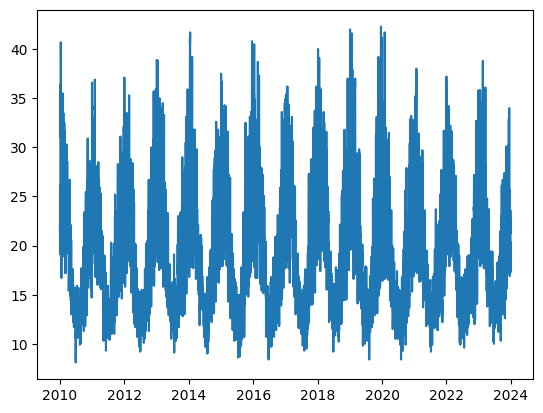

In [64]:
plt.plot(daily_data_x['date'], daily_data_x['temperature_max'])
plt.show()

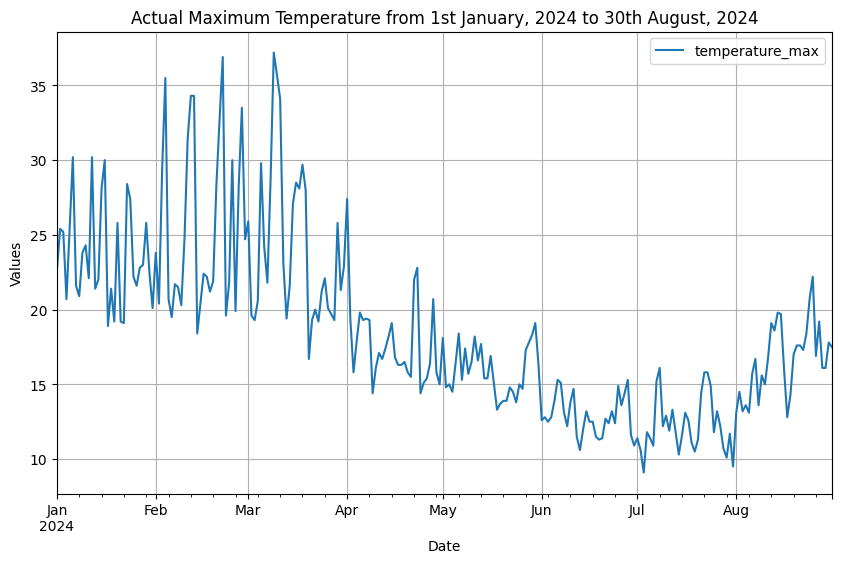

In [134]:
daily_data_y['temperature_max'].plot(figsize=(10, 6))  # 'figsize' controls the size of the plot

# Step 3: Customize the plot
plt.title('Actual Maximum Temperature from 1st January, 2024 to 30th August, 2024')  # Add a title
plt.xlabel('Date')  # Label for the X-axis
plt.ylabel('Values')  # Label for the Y-axis
plt.grid(True)  # Show grid
plt.legend(loc='upper right')  # Show legend
# plt.xticks(rotation=45)  # Rotate X-axis labels for better readability

# Show the plot
plt.show()

In [65]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity for each column in the regressor data
for column in daily_data_x.columns:
    adf_result = adfuller(daily_data_x[column])
    print(f'ADF Statistic for {column}: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')

    if adf_result[1] > 0.05:  # If p-value is greater than 0.05, the series is non-stationary
        print(f'{column} is likely non-stationary')

ADF Statistic for date: 25.229390986352403
p-value: 1.0
date is likely non-stationary
ADF Statistic for temperature_max: -4.20675238088761
p-value: 0.0006417717635368073
ADF Statistic for temperature_min: -5.029367126786503
p-value: 1.940708515934271e-05
ADF Statistic for apparent_temperature_max: -4.297061266021711
p-value: 0.00044944642800354
ADF Statistic for precipitation_sum: -38.52872581304614
p-value: 0.0
ADF Statistic for wind_speed_max: -11.011891797921214
p-value: 6.294999244707805e-20
ADF Statistic for year: -0.4464160847460577
p-value: 0.9020557606681648
year is likely non-stationary


In [67]:
daily_data_x.set_index('date', inplace=True)

In [89]:
var_model = VAR(daily_data_x)
var_model_fitted = var_model.fit(maxlags=365)

lag_order = var_model_fitted.k_ar

print(lag_order)

start_date = daily_data_x.index[-1]
end_date = pd.Timestamp('2024-08-30')
forecast_days = (end_date - start_date).days
# Use the last 'lag_order' observations from the dataset to predict the next 30 steps
last_observations = daily_data_x.values[-lag_order:]

# Forecast the next 30 steps
forecasted_values = var_model_fitted.forecast(last_observations, steps=forecast_days)

c:\py_me\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


365


In [90]:
forecasted_values

array([[ 1.96088590e+01,  9.94182956e+00,  1.92498734e+01,
        -1.67581658e+00,  2.56972821e+01,  2.02379313e+03],
       [ 2.13221319e+01,  1.35104012e+01,  2.03334651e+01,
         7.01944096e-01,  2.14984657e+01,  2.02397524e+03],
       [ 2.38499878e+01,  1.56329064e+01,  2.40048642e+01,
         4.45766508e-01,  2.68628679e+01,  2.02394347e+03],
       ...,
       [ 1.08780033e+01,  3.56302678e+00,  7.82656521e+00,
         4.14670032e+00,  1.81601818e+01,  2.02399343e+03],
       [ 1.13656516e+01,  5.28908330e+00,  8.32541640e+00,
        -8.53766995e-01,  2.11632685e+01,  2.02400656e+03],
       [ 1.74709158e+01,  8.14359617e+00,  1.30991506e+01,
         1.32803288e+00,  2.43904333e+01,  2.02399372e+03]])

In [91]:
forecast_dates = pd.date_range(start=start_date + pd.Timedelta(days=1), periods=len(forecasted_values), freq='D')
forecast_df = pd.DataFrame(forecasted_values, index=forecast_dates, columns=daily_data_x.columns)

print(forecast_df)

            temperature_max  temperature_min  apparent_temperature_max  \
2024-01-01        19.608859         9.941830                 19.249873   
2024-01-02        21.322132        13.510401                 20.333465   
2024-01-03        23.849988        15.632906                 24.004864   
2024-01-04        25.025118        13.490842                 26.040477   
2024-01-05        24.224407        15.248903                 23.786302   
...                     ...              ...                       ...   
2024-08-26         9.337818         3.356029                  7.122684   
2024-08-27        13.601092         4.751387                 10.233994   
2024-08-28        10.878003         3.563027                  7.826565   
2024-08-29        11.365652         5.289083                  8.325416   
2024-08-30        17.470916         8.143596                 13.099151   

            precipitation_sum  wind_speed_max         year  
2024-01-01          -1.675817       25.697282  202

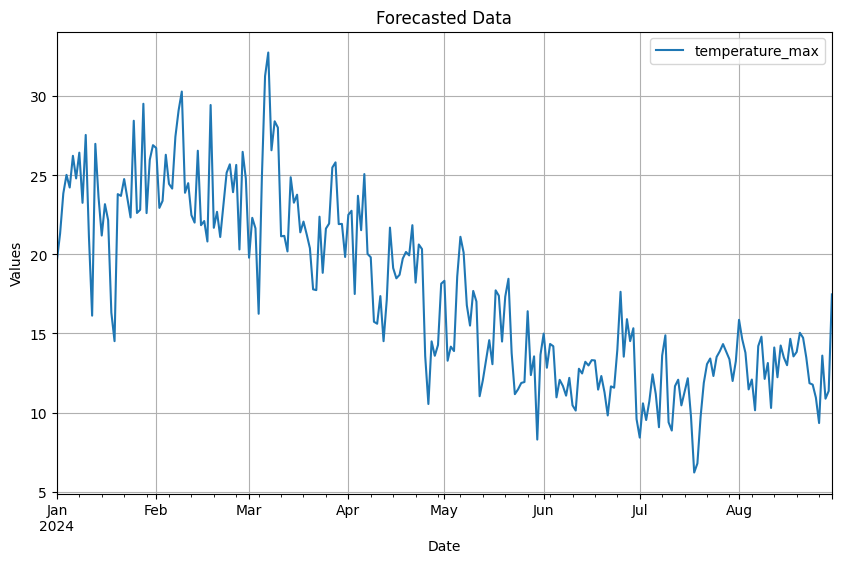

In [133]:
forecast_df.index = pd.to_datetime(forecast_df.index)

# Step 2: Plot all columns in the DataFrame against the date index
forecast_df['temperature_max'].plot(figsize=(10, 6))  # 'figsize' controls the size of the plot

# Step 3: Customize the plot
plt.title('Forecasted Data')  # Add a title
plt.xlabel('Date')  # Label for the X-axis
plt.ylabel('Values')  # Label for the Y-axis
plt.grid(True)  # Show grid
plt.legend(loc='upper right')  # Show legend
# plt.xticks(rotation=45)  # Rotate X-axis labels for better readability

# Show the plot
plt.show()

In [98]:
# Find the common date range between the forecast and actual data
common_dates = forecast_df.index.intersection(daily_data_y.index)

# Filter both DataFrames to include only the common dates
forecast_df_filtered = forecast_df.loc[common_dates]
daily_data_y_filtered = daily_data_y.loc[common_dates]

# Now you can extract the true and predicted values for those common dates
y_true = daily_data_y_filtered['temperature_max']
y_pred = forecast_df_filtered['temperature_max']

In [99]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Error (MAE): 3.4880737480484396
Mean Squared Error (MSE): 20.04724570775243
Root Mean Squared Error (RMSE): 4.477415069853635
Mean Absolute Percentage Error (MAPE): 18.05%


Model Design and Training using Random Forest Classifier

In [159]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.dates as mdates

In [144]:
# Load the data
data = pd.read_csv('hourly_cleaned_data.csv')

# Preprocess the data
data['time'] = pd.to_datetime(data['time'])
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['day'] = data['time'].dt.day
data['hour'] = data['time'].dt.hour

# Create the target variable
data['is_rainy'] = (data['rain'] > 0).astype(int)

In [145]:
data

,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,wind_speed_10m,wind_gusts_10m,year,month,day,hour,is_rainy
0,2010-01-01 00:00:00,20.0,75,15.5,0.2,0.2,5.4,28.8,2010,1,1,0,1
1,2010-01-01 01:00:00,20.3,72,15.1,0.2,0.2,7.3,32.0,2010,1,1,1,1
2,2010-01-01 02:00:00,20.0,72,14.9,0.1,0.1,9.8,35.3,2010,1,1,2,1
3,2010-01-01 03:00:00,20.3,71,14.8,0.0,0.0,11.5,31.0,2010,1,1,3,0
4,2010-01-01 04:00:00,21.5,66,14.9,0.0,0.0,12.0,29.9,2010,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128563,2024-08-31 19:00:00,13.5,64,6.8,0.0,0.0,24.8,45.4,2024,8,31,19,0
128564,2024-08-31 20:00:00,13.6,65,7.2,0.0,0.0,26.3,47.2,2024,8,31,20,0
128565,2024-08-31 21:00:00,13.8,66,7.5,0.0,0.0,29.4,54.0,2024,8,31,21,0
128566,2024-08-31 22:00:00,14.0,67,8.0,0.1,0.1,30.1,55.4,2024,8,31,22,1


In [146]:
# Select features
features = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
            'wind_speed_10m', 'wind_gusts_10m', 'month', 'day', 'hour']

In [149]:
# Split the data into training (2010-2023) and testing (2024)
train_data = data[data['year'] < 2024]
test_data = data[data['year'] == 2024]

X_train = train_data[features]
y_train = train_data['is_rainy']
X_test = test_data[features]
y_test = test_data['is_rainy']

X_train

,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_gusts_10m,month,day,hour
0,20.0,75,15.5,5.4,28.8,1,1,0
1,20.3,72,15.1,7.3,32.0,1,1,1
2,20.0,72,14.9,9.8,35.3,1,1,2
3,20.3,71,14.8,11.5,31.0,1,1,3
4,21.5,66,14.9,12.0,29.9,1,1,4
...,...,...,...,...,...,...,...,...
122707,10.5,95,9.8,4.8,15.5,12,31,19
122708,11.5,92,10.3,3.3,9.0,12,31,20
122709,13.6,85,11.1,1.3,9.4,12,31,21
122710,15.4,78,11.5,3.1,13.7,12,31,22


In [151]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[ 0.93253331,  0.17132366,  1.67685916, ..., -1.60163575,
        -1.67376173, -1.66132477],
       [ 0.98514271, -0.0066744 ,  1.57116998, ..., -1.60163575,
        -1.67376173, -1.51686175],
       [ 0.93253331, -0.0066744 ,  1.51832538, ..., -1.60163575,
        -1.67376173, -1.37239873],
       ...,
       [-0.18980062,  0.7646505 ,  0.51427812, ...,  1.58808131,
         1.73550594,  1.37239873],
       [ 0.1258558 ,  0.34932171,  0.6199673 , ...,  1.58808131,
         1.73550594,  1.51686175],
       [ 0.47658515, -0.0066744 ,  0.85776797, ...,  1.58808131,
         1.73550594,  1.66132477]])

In [152]:
# Create and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5002
           1       0.72      0.31      0.43       854

    accuracy                           0.88      5856
   macro avg       0.80      0.65      0.68      5856
weighted avg       0.87      0.88      0.86      5856


Confusion Matrix:
[[4896  106]
 [ 588  266]]


In [153]:
# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': clf.feature_importances_})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


Feature Importance:
                feature  importance
4        wind_gusts_10m    0.173099
1  relative_humidity_2m    0.169124
3        wind_speed_10m    0.140973
2          dew_point_2m    0.123590
0        temperature_2m    0.122627
7                  hour    0.103533
6                   day    0.096142
5                 month    0.070912


In [163]:
# Function to predict rain for a specific date
def predict_rain_for_date(year, month, day, hour, temp, humidity, dew_point, wind_speed, wind_gusts):
    new_data = pd.DataFrame({
        'temperature_2m': [temp],
        'relative_humidity_2m': [humidity],
        'dew_point_2m': [dew_point],
        'wind_speed_10m': [wind_speed],
        'wind_gusts_10m': [wind_gusts],
        'month': [month],
        'day': [day],
        'hour': [hour]
    })
    new_data_scaled = scaler.transform(new_data)
    prediction = clf.predict(new_data_scaled)
    probability = clf.predict_proba(new_data_scaled)[:, 1]
    return prediction[0], probability[0]

In [167]:
# Example usage
example_date = test_data.iloc[50]  # Get the first row of 2024 data
print(example_date)

time                     2024-01-03 02:00:00
temperature_2m                          23.2
relative_humidity_2m                      86
dew_point_2m                            20.7
precipitation                            0.2
rain                                     0.2
wind_speed_10m                           3.1
wind_gusts_10m                          14.0
year                                    2024
month                                      1
day                                        3
hour                                       2
is_rainy                                   1
predicted_rain                             1
predicted_probability                   0.79
correct_prediction                      True
Name: 122762, dtype: object


In [168]:
prediction, probability = predict_rain_for_date(
    2024,
    example_date['month'],
    example_date['day'],
    example_date['hour'],
    example_date['temperature_2m'],
    example_date['relative_humidity_2m'],
    example_date['dew_point_2m'],
    example_date['wind_speed_10m'],
    example_date['wind_gusts_10m']
)

print("\nExample Prediction for 2024:")
print(f"Actual: {'Rainy' if example_date['is_rainy'] == 1 else 'Not Rainy'}")
print(f"Predicted: {'Rainy' if prediction == 1 else 'Not Rainy'}")
print(f"Probability of rain: {probability:.2f}")

# Calculate overall accuracy for 2024
accuracy = (y_pred == y_test).mean()
print(f"\nOverall accuracy for 2024: {accuracy:.2f}")


Example Prediction for 2024:
Actual: Rainy
Predicted: Rainy
Probability of rain: 0.79

Overall accuracy for 2024: 0.88


In [169]:
import pickle

# Save the VAR model
with open('var_model.pkl', 'wb') as var_file:
    pickle.dump(var_model_fitted, var_file)
print("VAR model saved as var_model.pkl")

# Save the Random Forest Classifier model
with open('random_forest_model.pkl', 'wb') as rf_file:
    pickle.dump(clf, rf_file)
print("Random Forest model saved as random_forest_model.pkl")

VAR model saved as var_model.pkl
Random Forest model saved as random_forest_model.pkl
